# Analysys of the Segmentation Results 

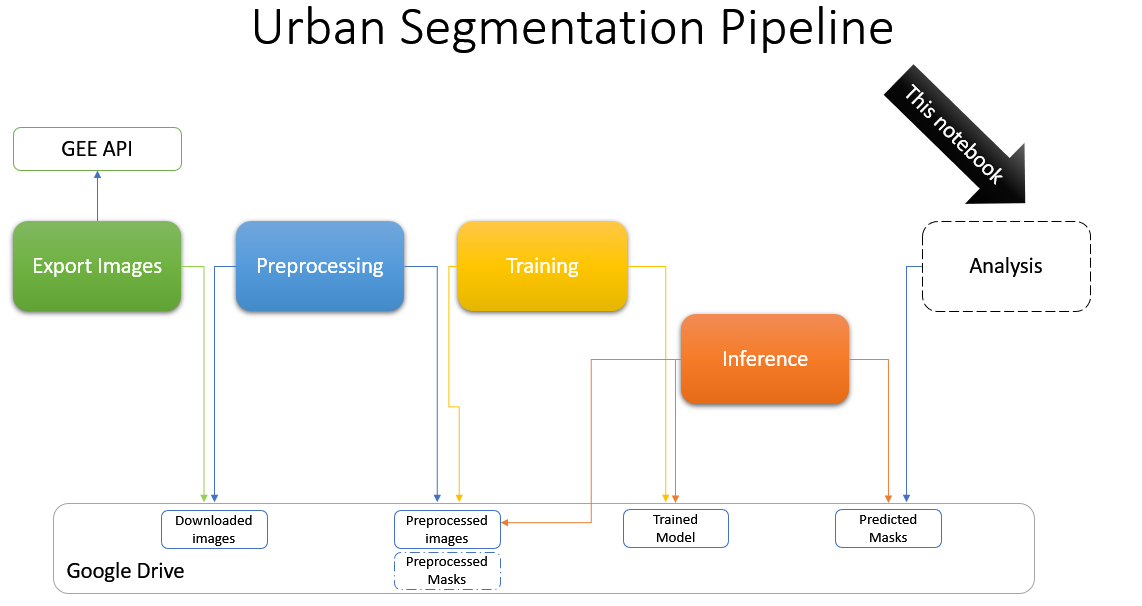

This notebook contains the Segmentation pipeline results analysis using fastai
It assumes that the dataset was already preprocessed and available in two directories:
- s2_resized - the input images
- esm_aligned - the ESM masks

A model was trained and saved: `models/best_model.pt`

Results file: `results_log.csv`

Test data and predidictions:
- s2_resized_test - images for test not used in training
- esm_resized_test - masks of the above test images (unused)
- preds - predicted masks based on test data


# Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install fastai wwf nbdev rasterio geopandas fastbook tiffile imagecodecs pytorch-ignite geemap -q

from wwf.utils import state_versions
state_versions(['wwf','rasterio','pytorch-ignite'])

     |████████████████████████████████| 46 kB 2.2 MB/s 
     |████████████████████████████████| 19.3 MB 6.6 MB/s 
     |████████████████████████████████| 1.0 MB 50.4 MB/s 
     |████████████████████████████████| 719 kB 56.1 MB/s 
     |████████████████████████████████| 31.0 MB 1.2 MB/s 
     |████████████████████████████████| 259 kB 66.1 MB/s 
     |████████████████████████████████| 2.0 MB 57.8 MB/s 
     |████████████████████████████████| 512 kB 54.7 MB/s 
     |████████████████████████████████| 68 kB 6.5 MB/s 
     |████████████████████████████████| 6.3 MB 30.5 MB/s 
     |████████████████████████████████| 16.7 MB 45.9 MB/s 
     |████████████████████████████████| 365 kB 52.0 MB/s 
     |████████████████████████████████| 1.2 MB 61.1 MB/s 
     |████████████████████████████████| 4.4 MB 49.9 MB/s 
     |████████████████████████████████| 8.8 MB 46.1 MB/s 
     |████████████████████████████████| 98 kB 8.3 MB/s 
     |████████████████████████████████| 95 kB 4.3 MB/s 
     |███████████████


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `wwf`, `rasterio`, and `pytorch-ignite` currently running at the time of writing this:
* `wwf` : 0.0.16 
* `rasterio` : 1.2.10 
* `pytorch-ignite` : 0.4.9 
---

In [ ]:
# Python General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil

from pathlib import Path
import glob
from tqdm.notebook import tqdm
import pprint as pp
from PIL import Image
import numpy as np

#Torch
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.transforms.functional import InterpolationMode
from torchvision.models.resnet import resnet18,resnet34,resnet50,resnet101
# from ignite.metrics import SSIM


#rasterio
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling

#fastai
from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos
from fastai.data import *
from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize
from fastai.layers import Mish
from fastai.losses import BaseLoss,DiceLoss,FocalLossFlat
from fastai.optimizer import ranger,Adam
from fastai.torch_core import tensor
from fastai.vision.all import *
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.vision import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.basics import *

import ee
import geemap
from ipyleaflet import Map, basemaps

In [ ]:
DRV = '/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/'

# preds_dir='/content/drive/MyDrive/2022/S1/3624_Final_Project/saitama_preds_jul26'
#USED PRED images on drive
# preds_imgs = glob.glob(os.path.join(preds_dir,'*.tif'))

#Image assets on GEE (jul26 saitama preds)
list_imgs = []
for i in range(1,50):
  list_imgs.append('projects/ee-liadleviraz/assets/pred_s2_img_'+str(i))
print(list_imgs[-3:])

['projects/ee-liadleviraz/assets/pred_s2_img_47', 'projects/ee-liadleviraz/assets/pred_s2_img_48', 'projects/ee-liadleviraz/assets/pred_s2_img_49']


In [ ]:
if not Map:
  Map.clear()
center = [35.89,139.59]
zoom = 11.4

# Map = geemap.Map(basemap=basemaps.Gaode.Satellite, center=center, zoom=zoom) #zoom > 7 doesn't show
#after you see the map change the map baseline to 'Satellite' on the Menu
Map = geemap.Map(center=center, zoom=zoom)

#Uncomment to use our exported image of saitama
rgb_img_asset = 'projects/ee-liadleviraz/assets/saitama_area2'
bg_img = ee.Image(rgb_img_asset)
rgb_img = ee.Image(bg_img.select(['B2','B3','B4']))
Map.addLayer(rgb_img, vis_params={  'min': 0,  'max': 3000}, name=rgb_img_asset,opacity=1)

for i,img_path in enumerate(list_imgs):
  dataset = ee.Image(img_path)
  b1 = ee.Image(dataset.select('b1'))
  resi_mask = b1.select('b1').gt(1);
  Map.addLayer(resi_mask, {'palette': ['red', 'green']}, '250-255-mask'+str(i));

Map

Map(center=[35.89, 139.59], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

In [ ]:
EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset'
os.chdir('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')
sys.path.append('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')

ESM_DIR = EXPORT_DIR + '/ESM'
S2_DIR = EXPORT_DIR + '/S2'


esm_aligned = os.path.join(EXPORT_DIR ,'esm_aligned/')
s2_resized = os.path.join(EXPORT_DIR,'s2_resized')
S2_TEST_DIR = s2_resized + '_test'
ESM_TEST_DIR = esm_aligned + '_test'


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' #GOOD FOR DEBUGGING
print('Using device:', device)

Using device: cpu


In [ ]:
# from libs.preprocess import *
# from libs.metrics import *
# from libs.multichannel import *
# from libs.metrics import _fast_hist

In [ ]:
trn = glob.glob(os.path.join(s2_resized,'*.tif'))
trn_number_files = len(trn)
print('{} train files in {}'.format(trn_number_files,s2_resized))
tst = glob.glob(os.path.join(S2_TEST_DIR,'*.tif'))
tst_number_files = len(tst)
print('{} test files in {}'.format(tst_number_files,S2_TEST_DIR))

640 train files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized
60 test files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test


### Classes codes decoder dictionary (0,1,2,3)->(0,1,250,255)

In [ ]:
codes = ['0_No_Data','1_Land','250_Non_Resi_BU','255_Resi_BU']
codes

['0_No_Data', '1_Land', '250_Non_Resi_BU', '255_Resi_BU']

In [ ]:
# From np.unique(mask)
mask_vals = {0:0,1:1,2:250,3:255}
MERGE_BG_CLASSES=True
if(MERGE_BG_CLASSES):
  code2class = {0:0,1:250,2:255}
  class2code={0:0,250:1,255:2}
  class2desc={0:'Other',250:'Non Resi',255:'Resi'}

In [ ]:
fnames = get_image_files(s2_resized)
lbl_names = get_image_files(esm_aligned)
fnames,lbl_names

((#640) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_1.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_2.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_4.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_6.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_16.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_14.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_15.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_19.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_22.tif')...],
 (#640) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif'),Path('/content

In [ ]:
img_fn = fnames[3].name
msk = get_msk(img_fn,esm_aligned)

In [ ]:
cm='brg_r' #'nipy_spectral_r'

In [ ]:
# f,axs = plt.subplots(1,2,figsize=(10,10))
# msk.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs[0])
msk2 = get_msk(img_fn,esm_aligned,mask_vals,merge_bg=True)
# msk2.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs[1])
np.unique(tensor(msk),return_counts=True),np.unique(tensor(msk2),return_counts=True)

((array([0, 1, 2, 3], dtype=uint8), array([  293, 52556,   180, 36971])),
 (array([0, 1, 2, 3], dtype=uint8), array([    1, 52848,   180, 36971])))

In [ ]:
msk.shape,msk2.shape

((300, 300), (300, 300))

In [ ]:
def get_counts(a,b):
  print('\n counts:',a.shape,b.shape)
  print(np.unique(tensor(a),return_counts=True),'\n',np.unique(tensor(b),return_counts=True))

def prep_hist_no_bg(inp,targ):
  '''
  prepare tensors for evaluation
  '''
  get_counts(inp,targ)

  targ[targ == 0]=1
  targ[0,0]=0
  inp[inp == 0]=1
  inp[0,0]=0
  targ2=targ.type(torch.IntTensor)
  inp2=inp.type(torch.IntTensor)
  
  get_counts(inp2,targ2)
  
  targ = targ2.squeeze(1).cpu()
  pred=inp2.squeeze(1).cpu()#.argmax(dim=1).cpu()
  n_clss=len(np.unique(inp2))
  
  print('\nn_cls=',n_clss,targ.shape,pred.shape)
  hist = torch.zeros((n_clss, n_clss)).cpu()
  for t, p in zip(targ, pred):
      hist += _fast_hist(t.flatten(), p.flatten(), n_clss)
  print(hist)
  return hist

In [ ]:
def dice_coefficient_no_bg(hist):
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    dice = (2 * A_inter_B) / (A + B + EPS)
    avg_dice = nanmean(dice)
    return avg_dice

In [ ]:
msk=transforms.ToTensor()(msk)
msk2=transforms.ToTensor()(msk2)
msk = msk.cpu()
msk2 = msk2.cpu()
n_clss=len(np.unique(msk))
print('acc={:.4f} \nper_cls_acc={:.4f} \nIoU={:.4f} \nDice={:.4f}'.format(*eval_metrics(msk,msk2,4)))

acc=0.9968 
per_cls_acc=0.7509 
IoU=0.7495 
Dice=0.7510


In [ ]:
def parse_file_name(full_path):
  return full_path.split(os.path.sep)[-1]

In [ ]:
def plot_predictions(path2plot):
  sait = glob.glob(os.path.join(path2plot,'*.tif'))
  sait = sorted(sait)
  f,axs = plt.subplots(7,7,figsize=(25,25))
  im_no = 0
  for i in range(7):
    for j in range(7):
      a = display_image(sait[im_no],bands=[1],cm=cm,title='{}'.format(parse_file_name(sait[im_no])),ax=axs[i,j],verbose=False)
      axs[i,j].axes.xaxis.set_visible(False)
      axs[i,j].axes.yaxis.set_visible(False)
      im_no+=1
  plt.axis("off")
  plt.tight_layout()
  plt.show()

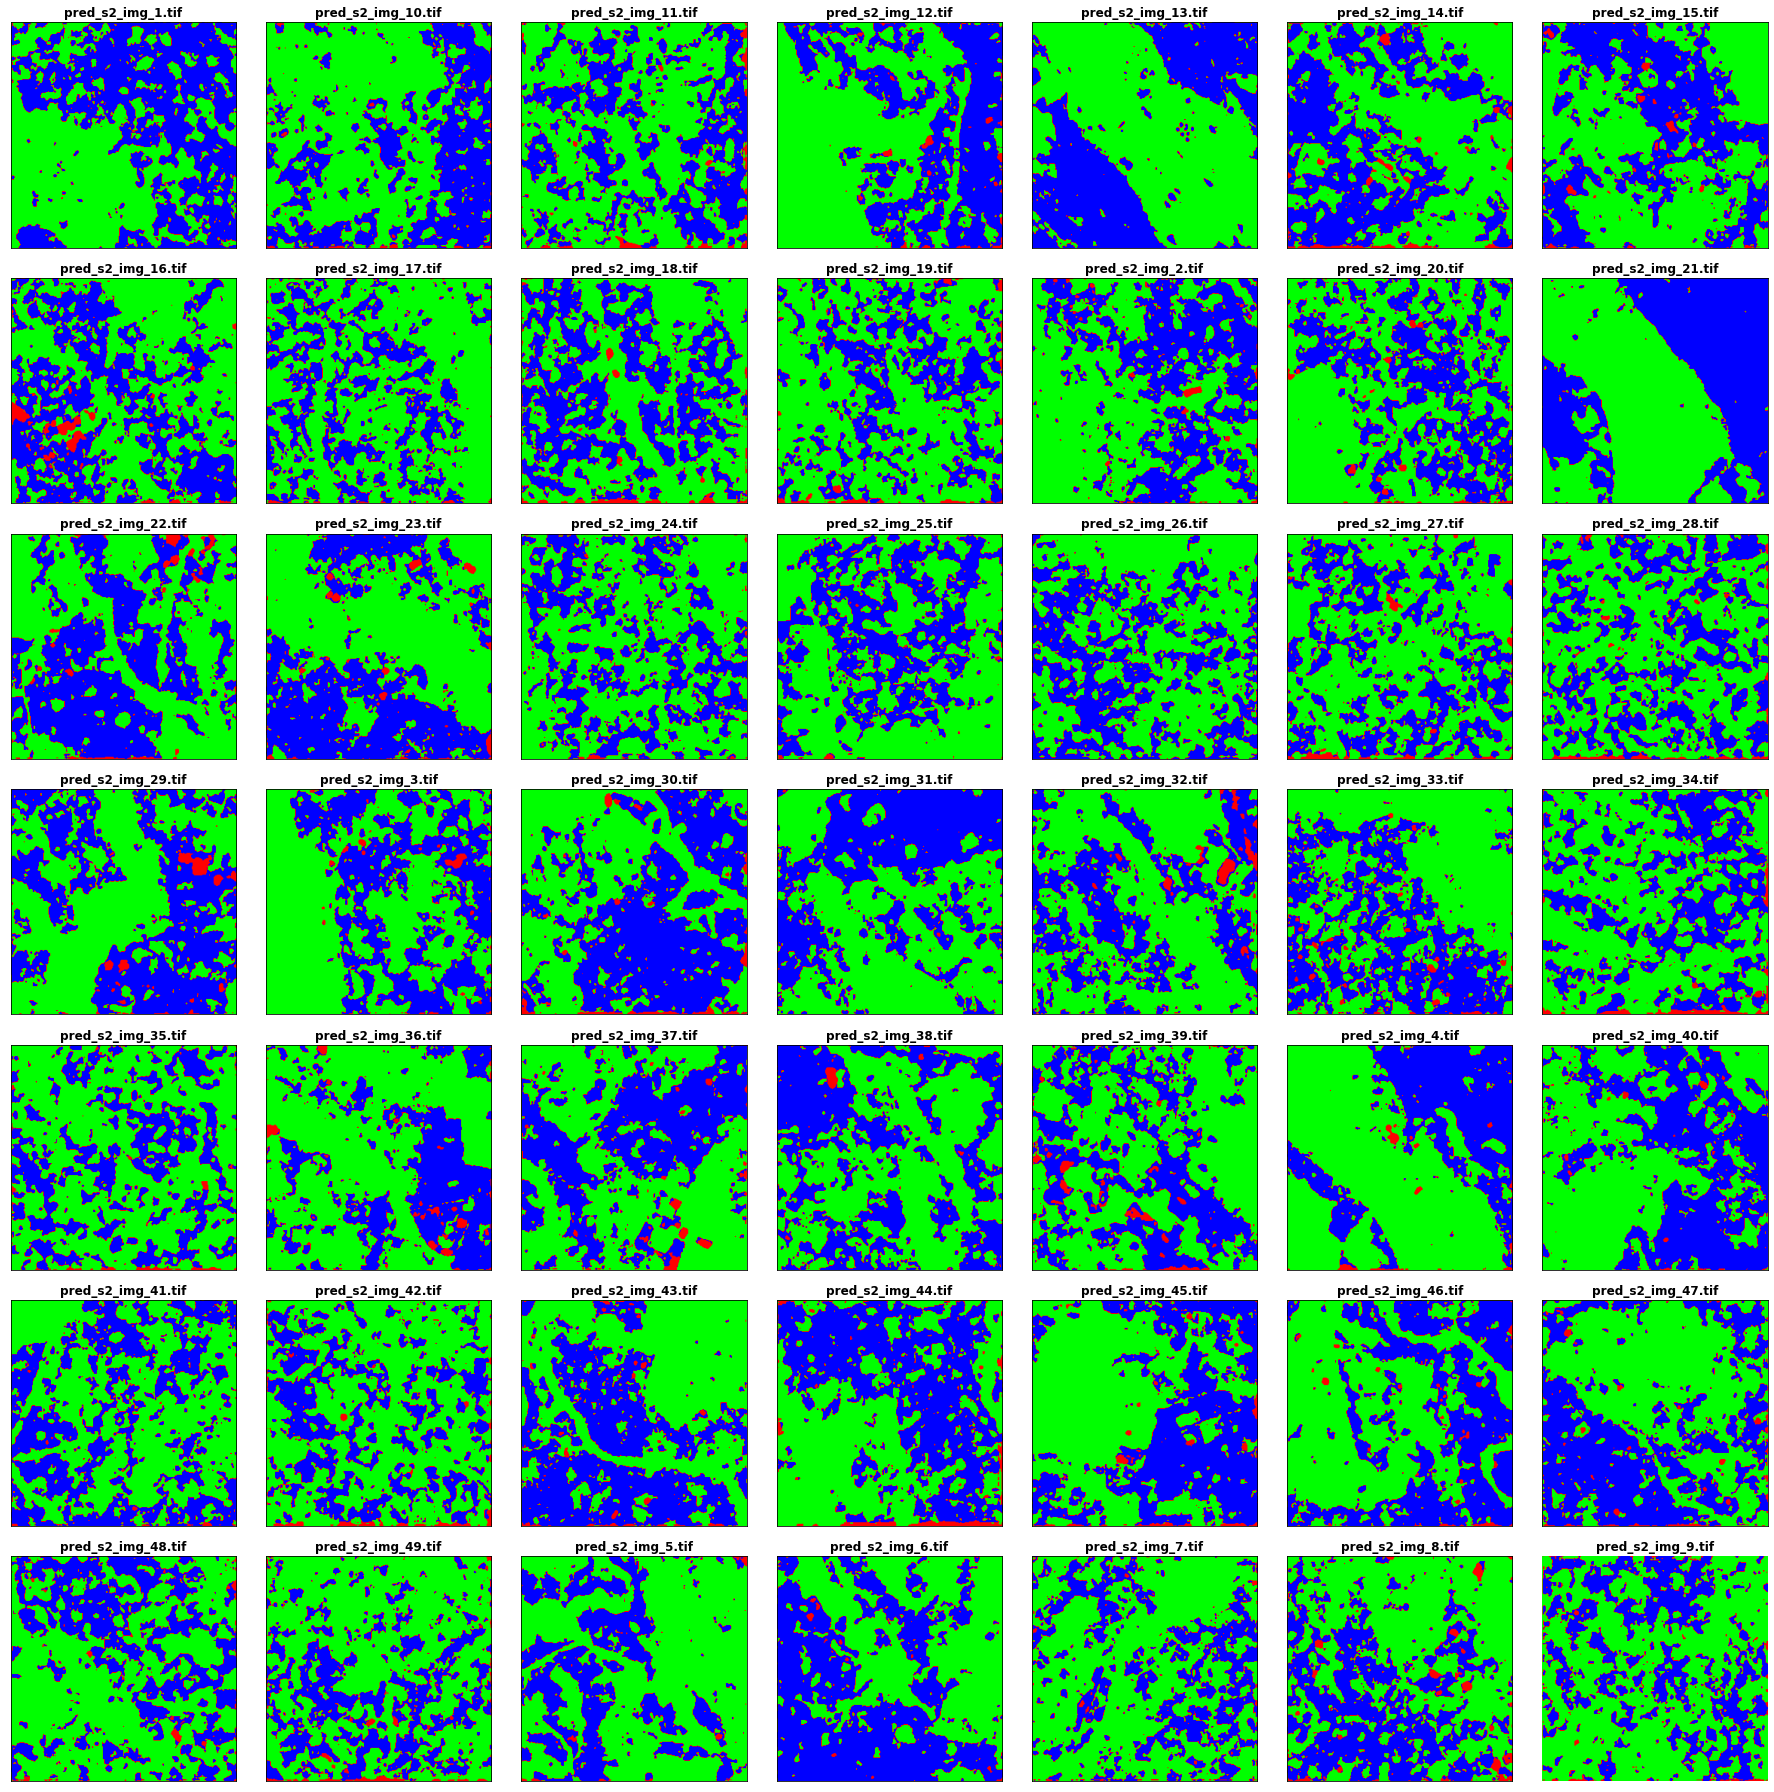

In [ ]:
SAITAMA1 = '/content/drive/MyDrive/2022/S1/3624_Final_Project/saitama_preds_jul18/'
plot_predictions(SAITAMA1)

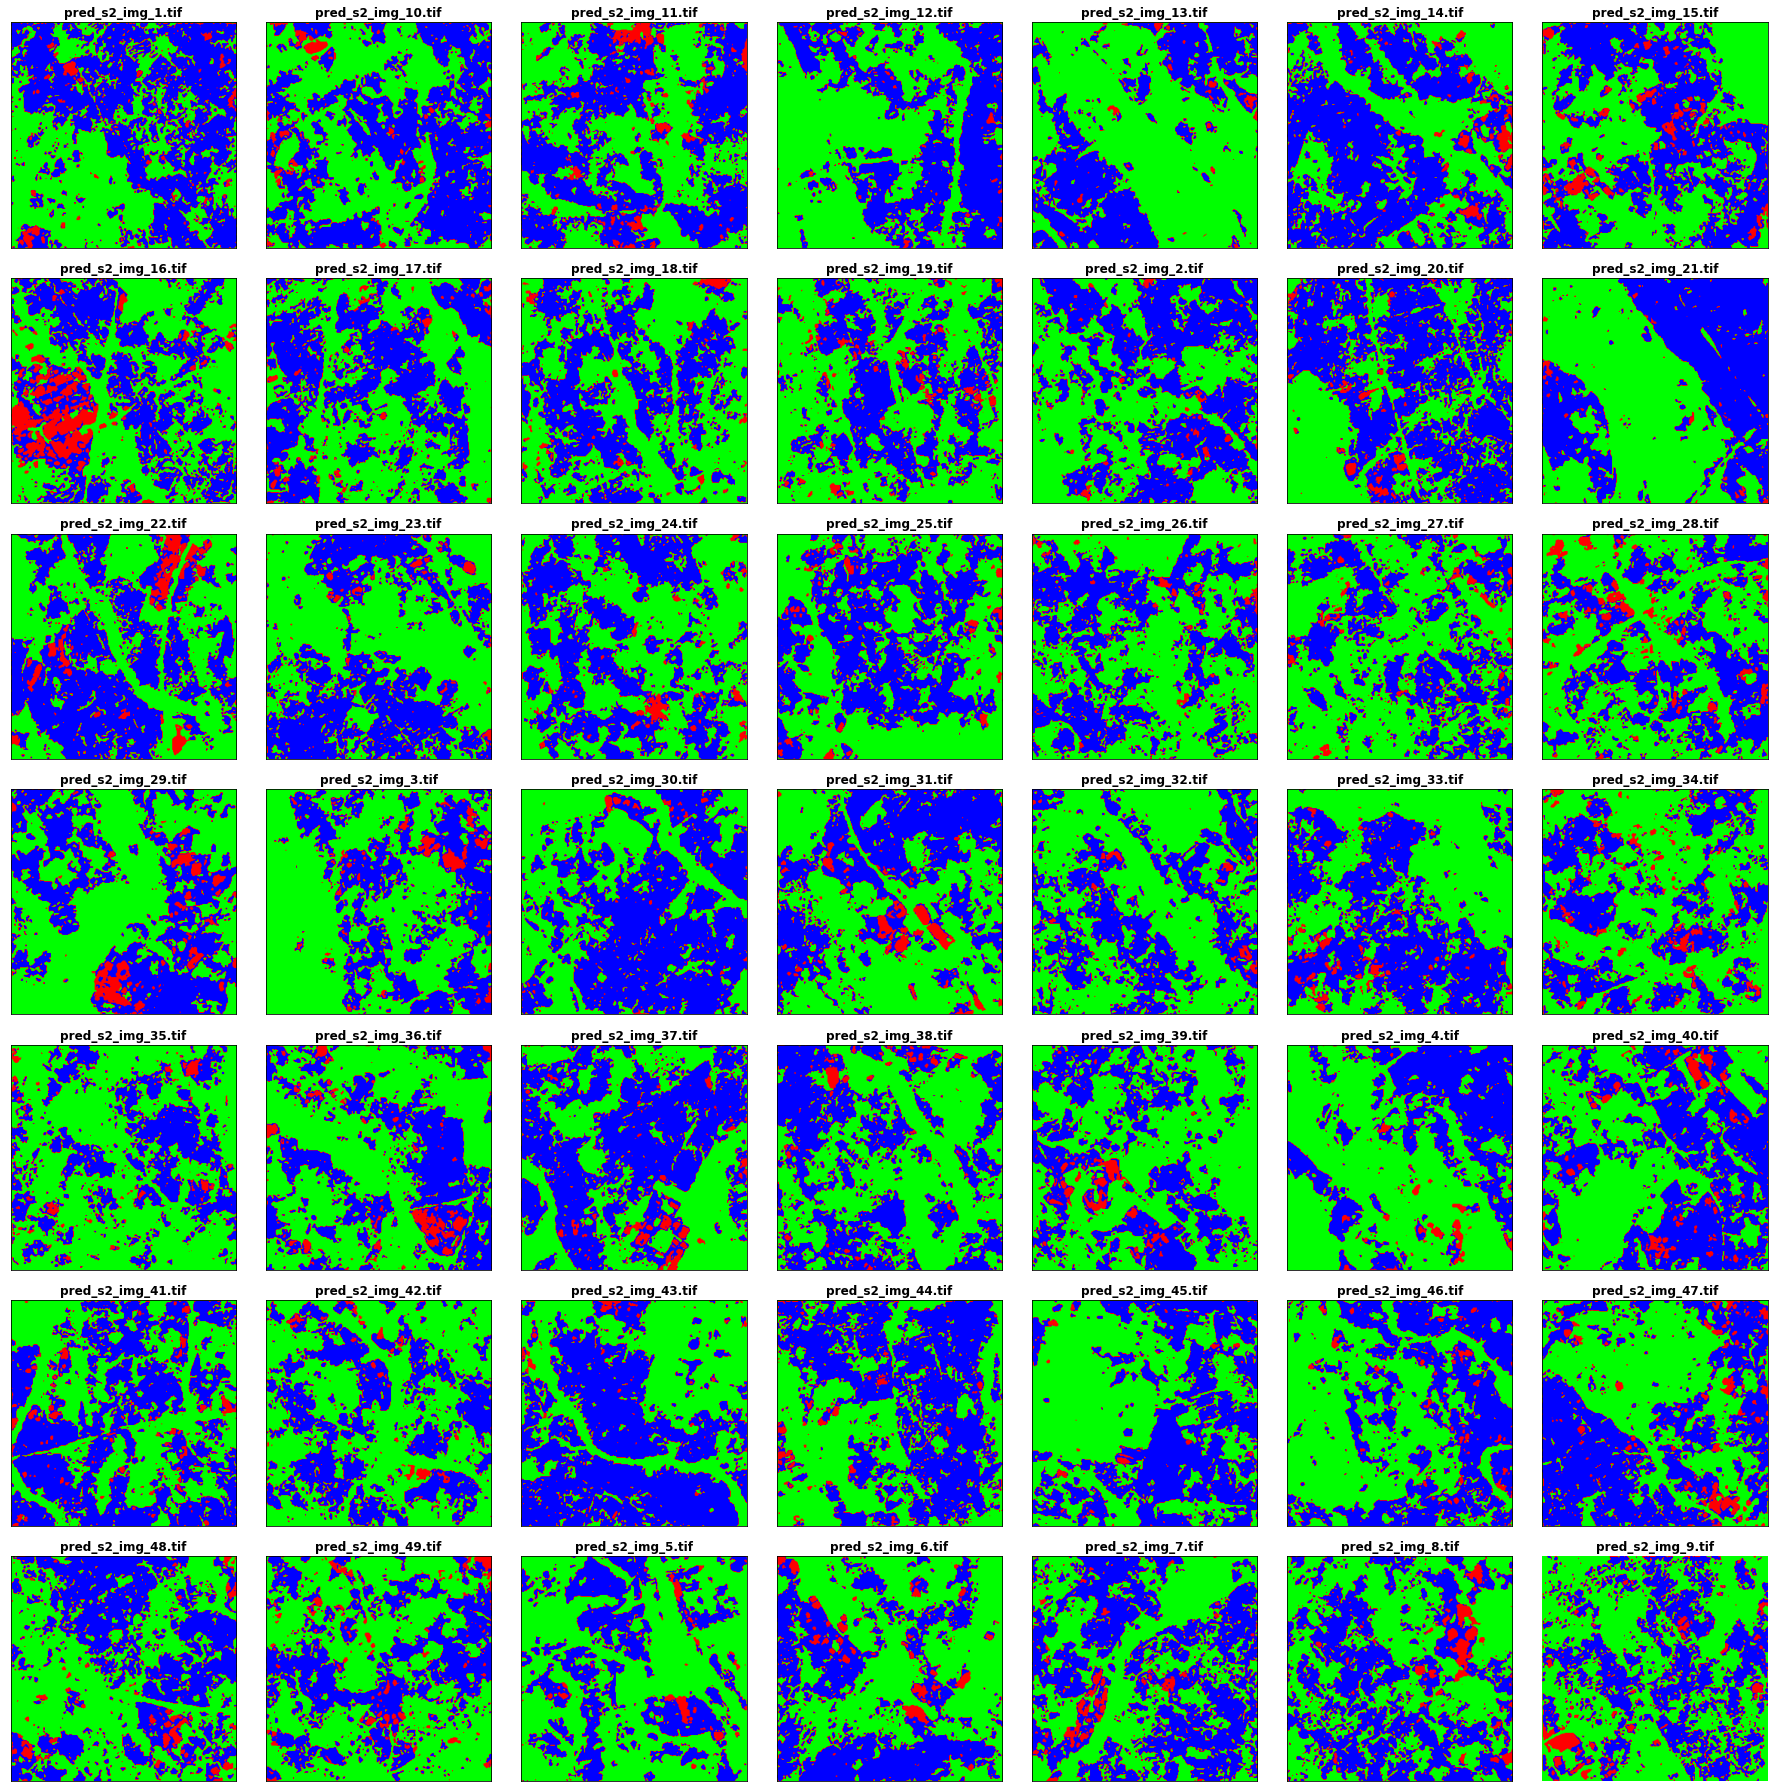

In [ ]:
SAITAMA = '/content/drive/MyDrive/2022/S1/3624_Final_Project/saitama_preds_jul26/'
plot_predictions(SAITAMA)

10


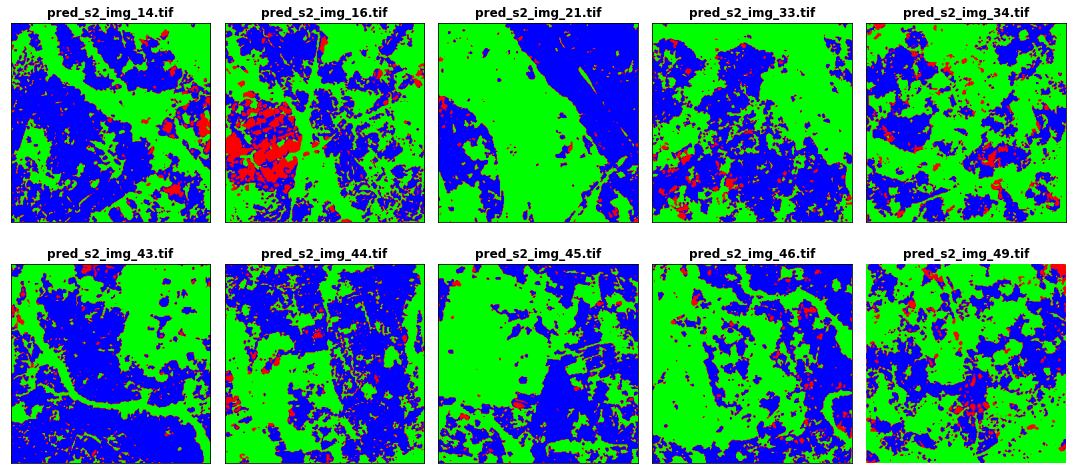

In [ ]:
img_2_plot = ['_21.tif','_33.tif','_34.tif','_43.tif','_44.tif','_45.tif','_46.tif','_49.tif','_14.tif','_16.tif']
sait3 = glob.glob(os.path.join(SAITAMA,'*.tif'))
sait2 = sorted(sait3)
sait2 = [img for img in sait2 if img[-7:] in img_2_plot]
print(len(sait2))
f,axs = plt.subplots(2,5,figsize=(15,7))
im_no = 0
for i in range(2):
  for j in range(5):
    a = display_image(sait2[im_no],bands=[1],cm=cm,title='{}'.format(parse_file_name(sait2[im_no])),ax=axs[i,j],verbose=False)
    axs[i,j].axes.xaxis.set_visible(False)
    axs[i,j].axes.yaxis.set_visible(False)
    im_no+=1
plt.axis("off")
plt.tight_layout()
plt.show()

## Store results of experiments and save to a log


In [ ]:
cols = ['datetime','model','num_epochs','loss_fn','batch_size','arch','optim','channels','pretrained','lr','valid_pct','trn_loss','val_loss','dice','augs','epoch_time']
# deeplab_results=pd.read_csv('logs/deeplab_results_log.csv',names=cols)
results=pd.read_csv('logs/exp_results_log.csv')

results = results.drop(['Unnamed: 12'],axis=1)
results.columns = cols
results.head(3)

datetime model  num_epochs           loss_fn  batch_size  \
0  05/07/2022 16:19:33  unet         500  CrossEntropyLoss          10   
1  05/07/2022 17:36:11  unet          50  CrossEntropyLoss          10   
2  05/07/2022 18:31:08  unet          50  CrossEntropyLoss          10   

       arch  optim  channels  pretrained     lr  valid_pct  trn_loss  \
0  resnet50  AdamW        15       False  0.001         50       NaN   
1  resnet50  AdamW        15       False  0.010         50  0.355048   
2  resnet50  AdamW        15       False  0.001         50  0.344223   

   val_loss      dice  \
0  0.871050  0.869400   
1  0.843407  0.846632   
2  0.829540  0.828388   

                                                                   augs  \
0  ['RandomSizedCrop', 'PadIfNeeded', 'VerticalFlip', 'RandomRotate90']   
1  ['RandomSizedCrop', 'PadIfNeeded', 'VerticalFlip', 'RandomRotate90']   
2  ['RandomSizedCrop', 'PadIfNeeded', 'VerticalFlip', 'RandomRotate90']   

               epoch_time  
0  0 days 00:00:05.080792  
1  0 days 00:00:00.044764  
2  0 days 00:00:00.043868

In [ ]:
report_cols=list(results.columns)
results = results[report_cols].fillna(0.0)
nn_results = results.drop(['channels','pretrained'],axis=1)

## Compare archs vs Val loss , Dice


In [ ]:
# results.groupby('arch').max('dice').sort_values(by='dice',ascending=False)
results.groupby('arch').max('dice').sort_values(by='dice',ascending=False)

num_epochs  batch_size  channels  pretrained    lr  valid_pct  \
arch                                                                      
resnet50         700          20        15       False  0.05         80   

          trn_loss  val_loss      dice  
arch                                    
resnet50  0.512549  0.884255  0.886953

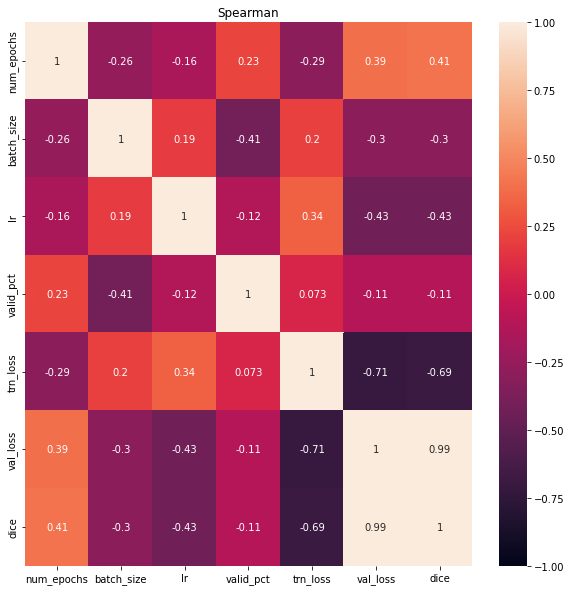

In [ ]:
f,ax2 = plt.subplots(1,1,figsize=(10,10))
corr = nn_results.corr()
scorr = nn_results.corr(method = 'spearman')
# cm = 'cividis'
# sns.heatmap(corr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm)
# ax1.set_title('Pearson')
sns.heatmap(scorr, annot = True,vmin=-1,vmax=1,ax=ax2)#,cmap=cm)
ax2.set_title('Spearman')

plt.show()

In [ ]:
import re
df = pd.DataFrame(columns=['loss_func','val_loss','Dice'])
loss_fncs=results['loss_fn'].str.split(',')
for i,result in enumerate(loss_fncs):
  
  if(result[0].startswith('DiceFocalLoss')):
    alpha,gamma=float(result[2]),float(result[3])
  else:
    alpha,gamma=np.nan,np.nan
  
  loss_func = re.sub('[^A-Za-z]+', '', result[0])
  df.loc[len(df)] = loss_func, \
                    float(results.iloc[i]['val_loss']), \
                    float(results.iloc[i]['dice'])
  # print(result[i][3],result[i][4])
np.unique(df['loss_func'])

array(['CrossEntropyLoss', 'FocalLoss', 'SoftDiceLoss'], dtype=object)

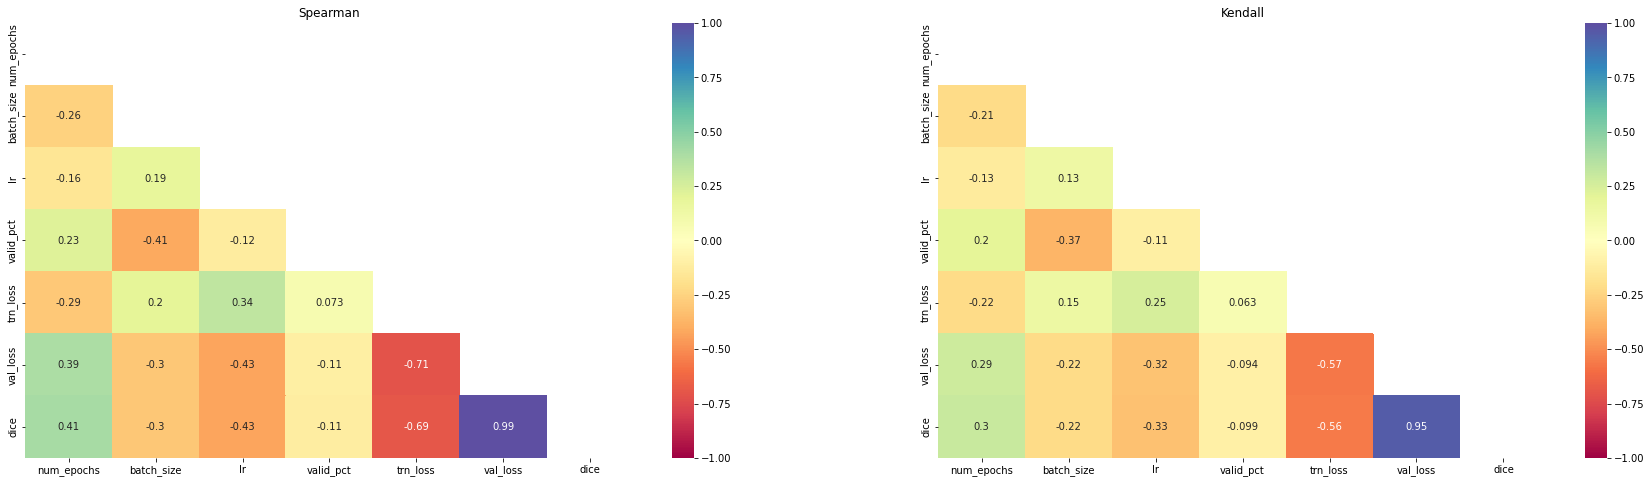

In [ ]:

f,(ax1,ax2) = plt.subplots(1,2,figsize=(30,8))
# corr = nn_results.corr()
scorr = nn_results.corr(method = 'spearman')
kcorr = nn_results.corr(method = 'kendall')

# Generate a mask for the upper triangle
smask = np.triu(np.ones_like(scorr, dtype=bool))
kmask = np.triu(np.ones_like(kcorr, dtype=bool))

cm = 'Spectral'
# sns.heatmap(corr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm)
# ax1.set_title('Pearson')
sns.heatmap(scorr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm,mask=smask)
ax1.set_title('Spearman')
sns.heatmap(kcorr, annot = True,vmin=-1,vmax=1,ax=ax2,cmap=cm,mask=kmask)
ax2.set_title('Kendall')

plt.show()


In [ ]:
# nn_results['epoch_time'] = nn_results['epoch_time'].str.replace(':', '').astype(float)
# nn_results['epoch_time'].head()

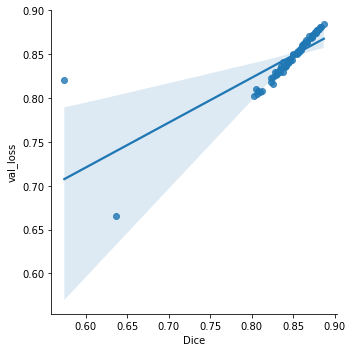

In [ ]:
sns.lmplot(x='Dice',y='val_loss',data=df,fit_reg=True) 

In [ ]:
# results.to_csv('results_log.csv', mode='a', index=False, header=False)
# scores_cols=['acc','per_cls_acc','IoU',	'Dice']
scores_cols=['dice']
# results[scores_cols].plot.bar()

In [ ]:
print('best mean score: {}'.format(results[scores_cols].mean(axis=1).max()))
# results.iloc[results[scores_cols].mean(axis=1).argmax()]

best mean score: 0.8869530760388573


# Compare various hyper params and architechtures results

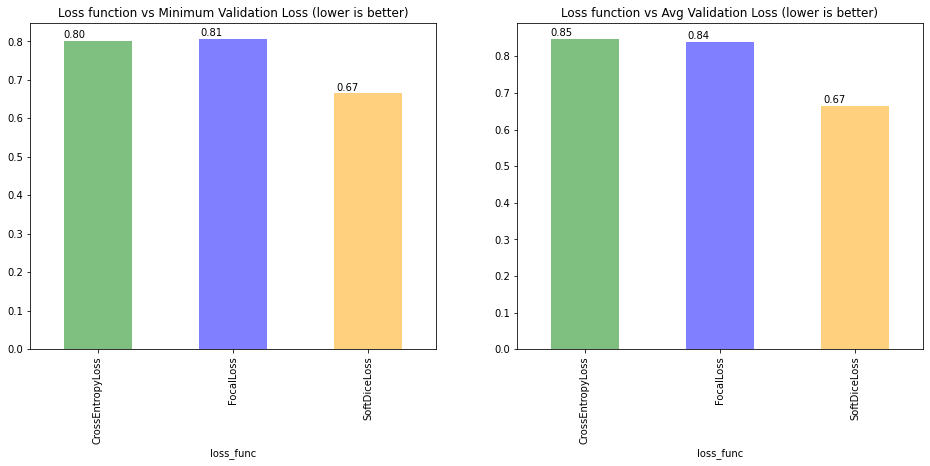

In [ ]:
colors=['Green','Blue','Orange','Red','Purple']
f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
df.groupby('loss_func')['val_loss'].min().plot.bar(title='Loss function vs Minimum Validation Loss (lower is better)',
                                                    color=colors,alpha=0.5,ax=ax1)
annotate(ax1)

df.groupby('loss_func')['val_loss'].mean().plot.bar(title='Loss function vs Avg Validation Loss (lower is better)',
                                                    color=colors,alpha=0.5,ax=ax2)
annotate(ax2)

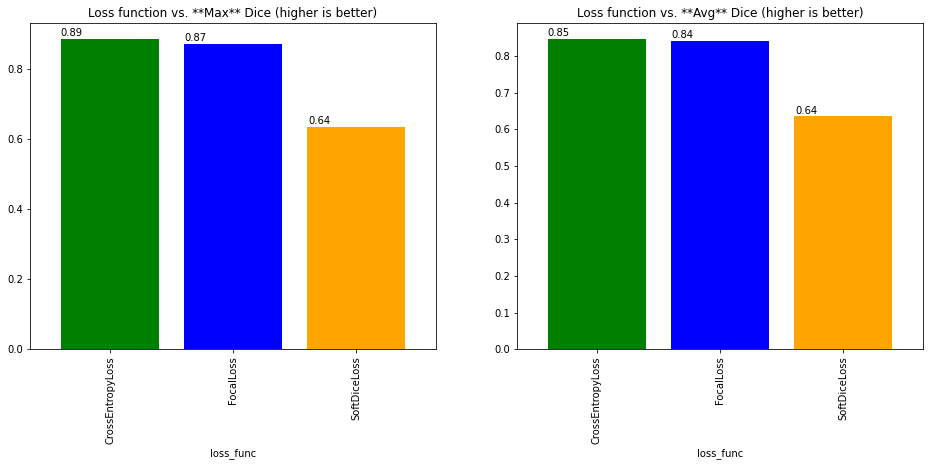

In [ ]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
df.groupby('loss_func')['Dice'].max().plot.bar(title='Loss function vs. **Max** Dice (higher is better)',ax=ax1,width=0.8,color=colors)
annotate(ax1)

df.groupby('loss_func')['Dice'].mean().plot.bar(title='Loss function vs. **Avg** Dice (higher is better)',ax=ax2,width=0.8,color=colors)
annotate(ax2)


In [ ]:
df.iloc[df['Dice'].argmax()]

loss_func    CrossEntropyLoss
val_loss             0.884255
Dice                 0.886953
Name: 11, dtype: object

### Compare class proprtions , similiarity of original and generated masks

First "predict" a mask for all the **training** data